A mock noteobok based on Chapter 3, Probabilistic Programming and Bayesian Methods for Hackers

https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [82]:
import numpy as np
import pandas as pd
import scipy.stats
import theano.tensor as T
import pymc3 as pm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)

In [3]:
data = pd.read_csv('mixture_data.csv', header=0).iloc[:, 0].values

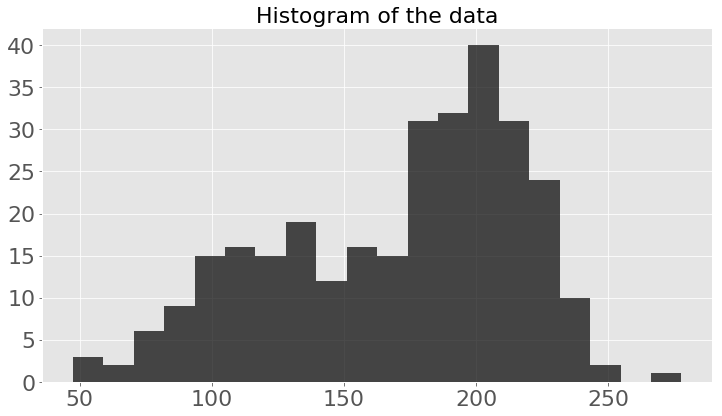

In [4]:
FONTSIZE = 22
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12, 6.5))

ax.hist(data, bins=20, color='k', histtype="stepfilled", alpha=0.7)
ax.set_title("Histogram of the data", fontsize=FONTSIZE)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)

In [27]:
with pm.Model() as model:
    p0 = pm.Uniform("p0", 0, 1)
    p1 = 1 - p0
    p = T.stack([p0, p1])
    cluster_assignments = pm.Categorical("cluster_assignments", p, 
                                         shape=data.shape[0], 
                                         testval=np.random.randint(0, 2, data.shape[0]))
    
    mus = pm.Normal("mus", 
                    mu=np.array([120, 210]), sd=np.array([10, 10]),
                    shape=2)
    sigmas = pm.Uniform('sigmas', 0, 100, shape=2)
    
    
    mu_i = pm.Deterministic("center_i", mus[cluster_assignments])
    sd_i = pm.Deterministic("sd_i", sigmas[cluster_assignments])
    
    observations = pm.Normal("obs", mu=mu_i, sd=sd_i, observed=data)
    

In [28]:
print("prior p0: {0:}".format(p0.tag.test_value))

prior p0: 0.5


In [7]:
print("prior cluster assignment:")
cluster_assignments.tag.test_value[0:10]

prior cluster assignment:


array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0])

In [8]:
print("prior centers:")
mus.tag.test_value

prior centers:


array([ 120.,  210.])

In [9]:
print("prior standard deviation:")
sigmas.tag.test_value

prior standard deviation:


array([ 50.,  50.])

In [9]:
print("inidividual centers:")
mu_i.tag.test_value[0:6]

inidividual centers:


array([ 210.,  210.,  120.,  210.,  120.,  210.])

In [10]:
print("individual sds:")
sd_i.tag.test_value[0:6]

individual sds:


array([ 50.,  50.,  50.,  50.,  50.,  50.])

In [ ]:
with model:
    start = pm.find_MAP()
    # important, need to specify the step1's vars with the following order
    step1 = pm.Metropolis(vars=[p, mus, sigmas])  
    step2 = pm.ElemwiseCategorical(vars=[cluster_assignments])    
    trace = pm.sample(21000, start=start, step=[step1, step2])

In [26]:
trace["mus"].shape, trace["sigmas"].shape

((20000, 2), (20000, 2))

In [30]:
with model:
    trace = pm.sample(10000, step=[step1, step2], trace=trace)
    

100%|██████████| 10500/10500 [00:56<00:00, 185.67it/s]


In [31]:
trace["mus"].shape, trace["sigmas"].shape, trace["p0"].shape

((31000, 2), (31000, 2), (31000,))

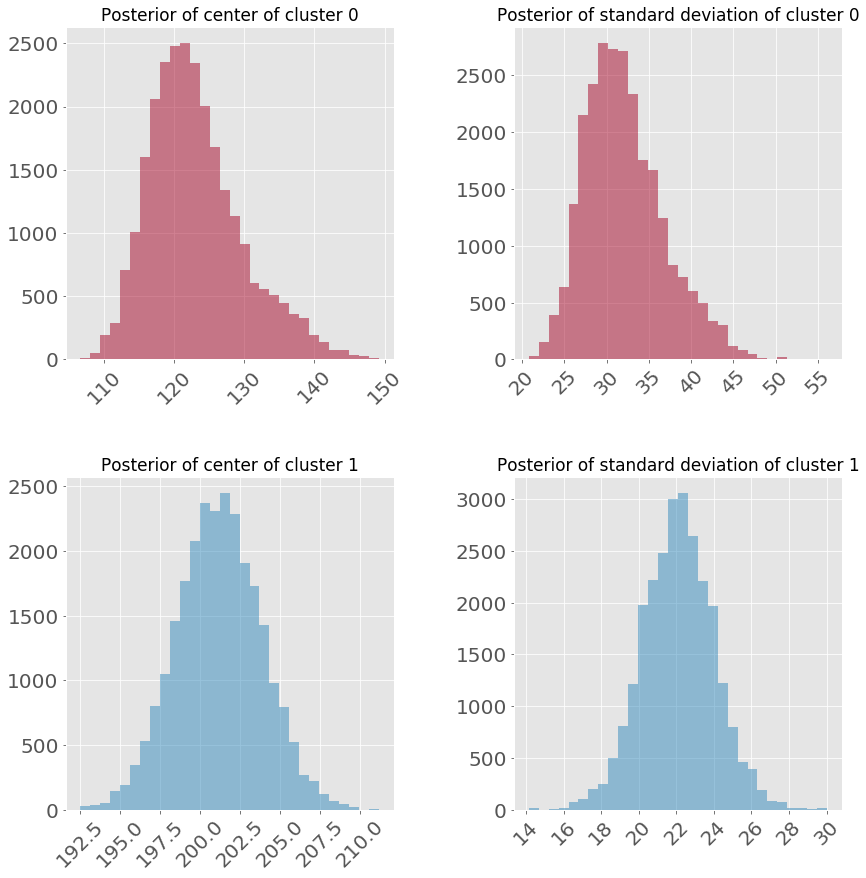

In [49]:
FONTSIZE = 20
plt.close('all')
fig = plt.figure(figsize=(12, 12))
gs = matplotlib.gridspec.GridSpec(2, 2)
colors = ["#A60628", "#348ABD"]
for i in range(2):
    
    # mu
    ax = plt.subplot(gs[i, 0])
    ax.hist(trace["mus"][5000:, i], bins=30,  histtype="stepfilled", color=colors[i], alpha=0.5)
    ax.set_title('Posterior of center of cluster {0:}'.format(i), fontsize=FONTSIZE*0.85)
    adjustAxeProperties(ax, FONTSIZE, 45, FONTSIZE, 0)    
    
    # sigma
    ax = plt.subplot(gs[i, 1])
    ax.hist(trace["sigmas"][5000:, i], bins=30,  histtype="stepfilled", color=colors[i], alpha=0.5)
    plt.title('Posterior of standard deviation of cluster {0:}'.format(i), fontsize=FONTSIZE*0.85)
    adjustAxeProperties(ax, FONTSIZE, 45, FONTSIZE, 0)
    
plt.tight_layout(pad=0, w_pad=5.0, h_pad=5.0)

In [45]:
trace["cluster_assignments"][::5]

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ..., 
       [0, 1, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]])

In [48]:
data.shape

(299,)

In [47]:
trace["cluster_assignments"].shape

(31000, 299)

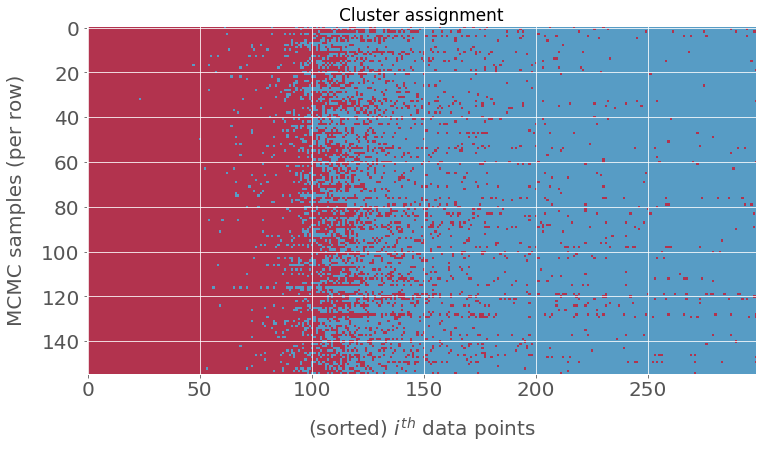

In [64]:
sorted_idx = np.argsort(data)

FONTSIZE = 20
plt.close("all")
fig, ax = plt.subplots(1, figsize=(12, 10))
ax.cmap = matplotlib.colors.ListedColormap(colors)
ax.imshow(trace["cluster_assignments"][::200, sorted_idx], 
          cmap=ax.cmap, alpha=0.8, aspect=1.0)
ax.set_xlabel(r'(sorted) $i^{th}$ data point', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('MCMC samples (per row)', fontsize=FONTSIZE, labelpad=15)
ax.set_title('Cluster assignment', fontsize=FONTSIZE*0.85)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)    


In [65]:
data[sorted_idx[100]], data[sorted_idx[150]]

(155.81594843783802, 181.3298787113024)

In the above plot, each row correpponds to a realization of the cluster assignments to 299 data points in the MCMC sampling process. 

Most ambuiguity happens in the range of [156, 181].


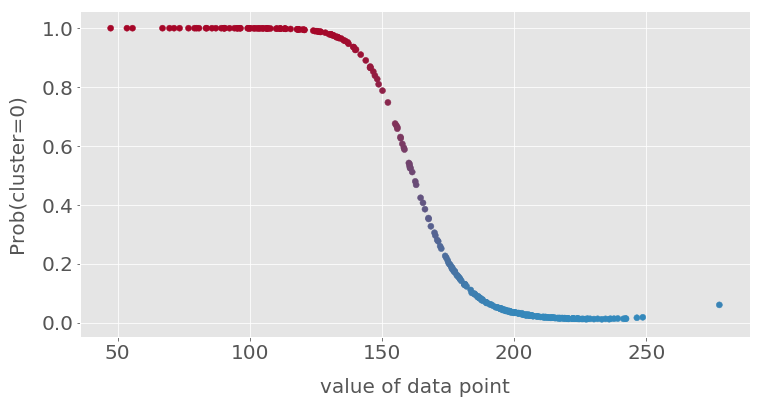

In [79]:
FONTSIZE = 20
plt.close("all")
fig, ax = plt.subplots(1, figsize=(12, 6))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
ax.scatter(data, 1-trace["cluster_assignments"].mean(axis=0), 
           cmap=cmap, c=trace["cluster_assignments"].mean(axis=0))
ax.set_xlabel('value of data point', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Prob(cluster=0)', fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)    

Below we overlay the original data with the posterior distributions from the MCMC samples to see if they fit each other

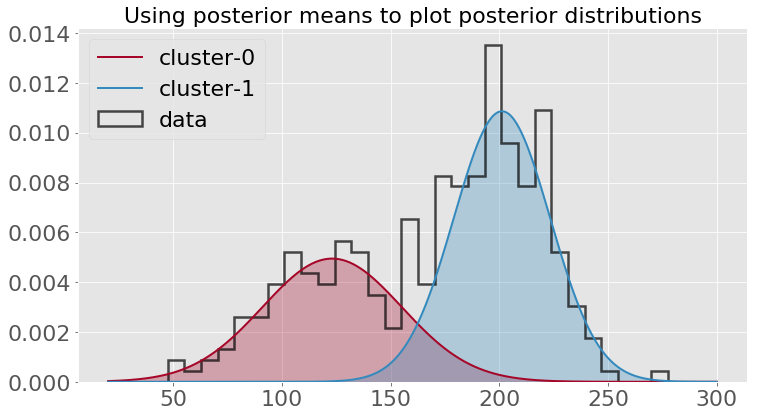

In [98]:
mu_posterior_mean = trace["mus"].mean(axis=0)
std_posterior_mean = trace["sigmas"].mean(axis=0)
p0_posterior_mean = trace["p0"].mean()

cluster0 = p0_posterior_mean * scipy.stats.norm.pdf(xvals, loc=mu_posterior_mean[0], scale=std_posterior_mean[0])
cluster1 = (1-p0_posterior_mean) * scipy.stats.norm.pdf(xvals, loc=mu_posterior_mean[1], scale=std_posterior_mean[1])


FONTSIZE = 22
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12, 6.5))

xvals = np.linspace(20, 300, 500)

# plot data
ax.hist(data, bins=30, color='k', histtype="step", normed=True, 
        lw=2.5, alpha=0.7, label="data")

# plot posterior distributions
ax.plot(xvals, cluster0, color=colors[0], lw=2, label='cluster-0')
ax.fill_between(xvals, cluster0, color=colors[0], alpha=0.3)

ax.plot(xvals, cluster1, color=colors[1], lw=2, label='cluster-1')
ax.fill_between(xvals, cluster1, color=colors[1], alpha=0.3)

ax.set_title('Using posterior means to plot posterior distributions', fontsize=FONTSIZE)

ax.legend(loc=2, fontsize=FONTSIZE)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)

